# Sentiment Analysis on Amazon Reviews

In [1]:
from fastai_old.text import *
import pandas as pd
import matplotlib.pyplot as pp
import seaborn
import html

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [169]:
%%capture
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

We use pathlib which makes directory traveral a breeze.

In [3]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)

The Fastai.text module introduces several custom tokens.

In [4]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/amazonReview/')
PATH.mkdir(exist_ok=True)

In [5]:
CLAS_PATH=Path('data/amazon_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/amazon_lm/')
LM_PATH.mkdir(exist_ok=True)

## 1. Downloading Data from source 
* Go to https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M
* Download the file amazon_review_full_csv.tar.gz
* Place in the folder data/amazonReview/
* Extract the file and make sure they are in data/amazonReview

In [21]:
#!tar xvzf data/amazonReview/amazon_review_full_csv.tar.gz -C data/amazonReview/
#!mv data/amazonReview/amazon_review_full_csv/* data/amazonReview/

*Note this is how the train.csv and test.csv files should be placed*

In [6]:
#!tree -L 1 ./data/amazonReview

./data/amazonReview
├── amazon_review_full_csv
├── models
├── readme.txt
├── test.csv
├── test_processed.csv
├── tmp
├── train.csv
└── train_processed.csv

3 directories, 5 files


## 2. Preparing data for use

In [184]:
train_df = pd.read_csv("data/amazonReview/train.csv",header=None)
test_df = pd.read_csv("data/amazonReview/test.csv",header=None) 

In [185]:
# Adding column Names
train_df.columns=["Ratings","Summary","Review"]
test_df.columns=["Ratings","Summary","Review"]

In [26]:
train_df.describe()

,Ratings
count,3.000000e+06
mean,3.000000e+00
std,1.414214e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [25]:
train_df.head()

,Ratings,Summary,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [94]:
train_df[train_df.columns].count()

Ratings    3000000
Summary    2999924
Review     3000000
dtype: int64

In [85]:
test_df[test_df.columns].count()

Ratings    650000
Summary    649988
Review     650000
dtype: int64

In [60]:
#Average lenght of Reviews
train_df["Review"].str.len().sum()/len(train_df)

414.0307393333333

In [86]:
#Max and min of review
train_df["Review"].str.len().max(),train_df["Review"].str.len().min()

(1010, 4)

In [69]:
#Biggest Review
train_df["Review"][train_df["Review"].str.len().idxmax()]

'Kane and Abel come back again with their second LP on No Limit Records. This is the best cd they have put out after all the horrible music they put out after leaving No Limit. This album was produced by Beats by The Pound(Now as the Medicine Men). Kane and Abel rap about the only thing they know, crime, sex, violence, ghetto, and drugs. They use old elements from other songs like on "Time After Time" and "Solider Story". This album has too much bland music and they don\'t ever change their formula, with too many cameo apperances from below average rappers makes this LP boring. You can\'t tell whos Kane and whos Abel. Don\'t get me wrong the twinz can rhyme and they are one of the best on the tank. But with too many tracks, too many cameo apperances, and familiar formulas makes this album seem like a No Limit Compilation than a KAne and Abel cd. I would pick this up cause it does have good tracks but think to yourself, how much of the same formula can No Limit keep puting out for consu

In [65]:
#Smallest Review
train_df["Review"][train_df["Review"].str.len().idxmin()]

'good'

In [61]:
train_df["Review"].str.len().describe()

count    3.000000e+06
mean     4.140307e+02
std      2.368867e+02
min      4.000000e+00
25%      2.130000e+02
50%      3.670000e+02
75%      5.800000e+02
max      1.010000e+03
Name: Review, dtype: float64

In [26]:
test_df.head()

,Ratings,Summary,Review
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


Lets see how many reviews we have per rating

In [95]:
train_df.groupby(by='Ratings').count()

,Summary,Review
Ratings,,
1,599988,600000
2,599977,600000
3,599977,600000
4,599987,600000
5,599995,600000


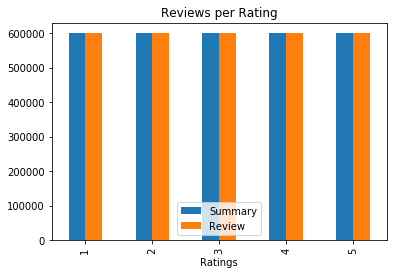

In [92]:
ss = train_df.groupby(by='Ratings').count()
ss.plot(kind='bar',title='Reviews per Rating').legend()

In [32]:
print("Number of training reviews {} and testing reviews {}".format(len(train_df["Ratings"]),len(test_df["Ratings"])))

Number of training reviews 3000000 and testing reviews 650000


## 3. Dataset Manipulation

* Let drop the column "Summary" as we dont need it.
* Remove all neutral reviews that is Rating=3
* Convert all the Ratings greater than 3 to 1 and smaller to 3 to 0.

In [186]:
train_df =train_df.drop("Summary",axis=1)
test_df =test_df.drop("Summary",axis=1)

In [187]:
train_df.head(5)

,Ratings,Review
0,3,Gave this to my dad for a gag gift after direc...
1,5,I hope a lot of people hear this cd. We need m...
2,5,I'm reading a lot of reviews saying that this ...
3,4,The music of Yasunori Misuda is without questi...
4,5,Probably the greatest soundtrack in history! U...


In [188]:
#Drop netural values
train_df.drop(train_df.index[train_df["Ratings"]==3],inplace=True)
test_df.drop(test_df.index[test_df["Ratings"]==3],inplace=True)

In [189]:
train_df.head(5)

,Ratings,Review
1,5,I hope a lot of people hear this cd. We need m...
2,5,I'm reading a lot of reviews saying that this ...
3,4,The music of Yasunori Misuda is without questi...
4,5,Probably the greatest soundtrack in history! U...
5,5,"There's a reason this CD is so expensive, even..."


In [190]:
train_df["Ratings"] = (train_df["Ratings"] > 3).astype(int)
test_df["Ratings"] = (test_df["Ratings"] > 3).astype(int)

In [191]:
train_df.head()

,Ratings,Review
1,1,I hope a lot of people hear this cd. We need m...
2,1,I'm reading a lot of reviews saying that this ...
3,1,The music of Yasunori Misuda is without questi...
4,1,Probably the greatest soundtrack in history! U...
5,1,"There's a reason this CD is so expensive, even..."


In [192]:
#Remaining Reviews
print("Training count {} and testing count {} ".format(len(train_df["Ratings"]),len(test_df["Ratings"])))

Training count 2400000 and testing count 520000 


In [193]:
#Count of postive and negative rating in training set
sum((train_df["Ratings"]==1).astype(int)),sum((train_df["Ratings"]==0).astype(int))

(1200000, 1200000)

In [194]:
#Count of positive and negative ratings in testing set
sum((test_df["Ratings"]==1).astype(int)),sum((test_df["Ratings"]==0).astype(int))

(260000, 260000)

In [106]:
train_df.groupby(by='Ratings').count()

,Review
Ratings,
0,1200000
1,1200000


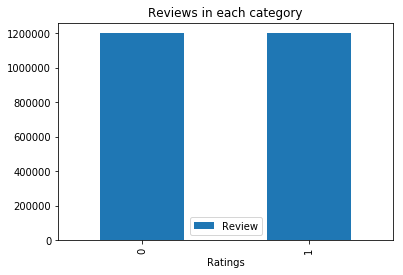

In [107]:
ss = train_df.groupby(by='Ratings').count()
ss.plot(kind='bar',title="Reviews in each category").legend()

As we can see we have equal number of postive and negative reviews for our model.

*Lets save our pre-processed data so that we dont have to from of it* 

In [55]:
#train_df.to_csv(PATH/'train_processed.csv', header=False, index=False)
#test_df.to_csv(PATH/'test_processed.csv', header=False, index=False)

## 4. Load preprocessed data

In [120]:
train_df = pd.read_csv(PATH/'train_processed.csv', header=None)
test_df = pd.read_csv(PATH/'test_processed.csv', header=None)

In [121]:
trn_texts = train_df[1]
val_texts = test_df[1]

trn_labels = train_df[0]
val_labels = test_df[0]

In [122]:
len(trn_texts),len(val_texts),len(trn_labels),len(val_labels)

(2400000, 520000, 2400000, 520000)

In [123]:
col_names = ['labels','text']

We use a random permutation np array to shuffle the text reviews.

In [124]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [125]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

We have 2400000 training reviews and testing 520000 reviews. 
Lets use half the available data because of memory limitations.

In [126]:
trn_texts = trn_texts[0:150000]
val_texts = val_texts[0:26000]

trn_labels = trn_labels[0:150000]
val_labels = val_labels[0:26000]

len(trn_texts),len(val_texts),len(trn_labels),len(val_labels)

(150000, 26000, 150000, 26000)

In [127]:
print("Percentage of positive reviews in training {}".format(sum(trn_labels)/len(trn_labels)*100))

Percentage of positive reviews in training 49.9


In [128]:
print("Percentage of positive reviews in testing {}".format(sum(val_labels)/len(val_labels)*100))

Percentage of positive reviews in testing 49.84615384615385


## 5. Benchmark Model

### 5.1 Bag of words model 

In [130]:
cv = CountVectorizer(binary=True)
cv.fit(trn_texts)
X = cv.transform(trn_texts)
X_test = cv.transform(val_texts)

In [131]:
X_test,X

(<26000x142390 sparse matrix of type '<class 'numpy.int64'>'
 	with 1366773 stored elements in Compressed Sparse Row format>,
 <150000x142390 sparse matrix of type '<class 'numpy.int64'>'
 	with 7984820 stored elements in Compressed Sparse Row format>)

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X,trn_labels ,train_size = 0.75)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### 5.2 Training

In [133]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.8453866666666666
Accuracy for C=0.05: 0.8549066666666667
Accuracy for C=0.25: 0.8542933333333333
Accuracy for C=0.5: 0.8519466666666666
Accuracy for C=1: 0.8477066666666667


In [135]:
final_model = LogisticRegression(C=0.25)
final_model.fit(X, trn_labels)
print ("Final Accuracy: %s" 
       % accuracy_score(val_labels, final_model.predict(X_test)))

Final Accuracy: 0.8619230769230769


### 5.3 Model evaluation and validation

In [197]:
print("Accuracy is {}".format(accuracy_score(val_labels, final_model.predict(X_test))*100))

Accuracy is 86.1923076923077


In [138]:
print(classification_report(val_labels, final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     13040
           1       0.86      0.87      0.86     12960

   micro avg       0.86      0.86      0.86     26000
   macro avg       0.86      0.86      0.86     26000
weighted avg       0.86      0.86      0.86     26000



In [139]:
print(confusion_matrix(val_labels, final_model.predict(X_test)))

[[11172  1868]
 [ 1722 11238]]


In [51]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('drawback', 1.6962772679792408)
('pleasantly', 1.6290577404620135)
('pleased', 1.508271883738639)
('complaint', 1.4885513098192598)
('refreshing', 1.4312076830983063)


In [52]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('disappointing', -2.207499156165661)
('stinks', -2.061598002823255)
('worst', -1.973639996172647)
('waste', -1.9668276970305771)
('disappointment', -1.915765152930414)


## 6. Using Transfer Learning

### 6.1 Prepare data for Language Model (LM) and Classifier (CLAS)

In [53]:
len(trn_texts),len(val_texts),len(trn_labels),len(val_labels)

(150000, 26000, 150000, 26000)

In [54]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

The pandas dataframe is used to store text data in a standard format of label followed by text columns.

In [55]:
#Saving data Classifier training
#Commented to prevent from overwriting

#df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
#df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data.

We first concat all the train(pos/neg) and test(pos/neg) reviews into a big chunk reviews. And then we use sklearn splitter to divide up the reviews texts into 90% training and 10% validation sets.


In [56]:
#For training of Language model we only need text. So we add all of the text that we have
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [57]:
len(trn_texts), len(val_texts)

(158400, 17600)

In [58]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

In [59]:
#saving data for Language Model Training
#df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
#df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

### 6.2 Language Model Data cleaning

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [6]:
import spacy 
spacy.load('en')

In [7]:
#Incase spacy gives an error on not having english module.
#!python -m spacy download en

In [8]:
chunksize=24000

In [9]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [10]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [11]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [13]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [68]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
0


In [69]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [70]:
#np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
#np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

Here is where we can load the pre-processed language model tokens from the Amazon Review data.

In [71]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [72]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 652322),
 ('the', 617137),
 (',', 444810),
 ('i', 348646),
 ('and', 330110),
 ('a', 303859),
 ('to', 299155),
 ('it', 274180),
 ('of', 241318),
 ('is', 218492),
 ('this', 218050),
 ('1', 165033),
 ('\n', 158408),
 ('xbos', 158400),
 ('xfld', 158400),
 ('t_up', 143977),
 ('in', 143374),
 ('for', 129865),
 ('that', 128498),
 ('was', 110475),
 ('you', 104963),
 ('"', 102619),
 ('not', 94114),
 ('but', 92620),
 ('with', 88828)]

The vocab is the unique set of all tokens in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.


In [73]:
max_vocab = 60000
min_freq = 2

In [74]:
# 'itos': 'int-to-string' 
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')           #vocab item for padding
itos.insert(0, '_unk_')           #vocab item for unknown words

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called collections.defaultdict to store our stoi mapping.

In [74]:
# 'stoi': 'string to int'
# It returns zero for unknown 
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

55702

In [76]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [77]:
#np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
#np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
#pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

Here is where we can load the pre-processed int version of the AmazonReview data, including the vocab int-to-str converter.

In [72]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [73]:
vs=len(itos)
vs,len(trn_lm)

(55702, 158400)

### 6.3 wikitext103 conversion

We are now going to build an english language model for the amazon reviews corpus. We use a technique called transfer learning to make learning process easier. In transfer learning a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the Amazon LM. 

In [81]:
#! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

*Note this is how the model files should be placed*

In [9]:
#!tree -L 1 ./data/amazonReview/models/wt103

./data/amazonReview/models/wt103
├── fwd_wt103.h5
└── itos_wt103.pkl

0 directories, 2 files


The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values with the target Amazon LM so that the weights can be loaded up.

In [75]:
#em_sz : size of each embedding vector
#nh :  number of hidden activations per layer
#nl : number of layers
em_sz,nh,nl = 400,1150,3

Note that the 'models' directory should be in 'amazonReview'.

In [76]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [77]:
# Loading the weights from forward wikitext-103
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target Amazon LM.

In [78]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [79]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the Amazon LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown amazon tokens that do not exist in wikitext103.

In [80]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying. 
* We will then replace the encoder weights with new_w turn into a tensor 
* Encoder and decoder uses the same weights

In [81]:
wgts['0.encoder.weight'] = T(new_w)      
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [48]:
wgts

OrderedDict([('0.encoder.weight',
              tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
                        1.9580e-02,  1.8548e-01],
                      [ 1.4854e-05, -2.3424e-05,  1.9693e-05,  ...,  2.1349e-05,
                        2.1776e-05, -1.2394e-05],
                      [-6.4137e-02,  1.2020e+00, -1.5905e-02,  ...,  1.0857e-02,
                       -8.9950e-01,  3.0268e-01],
                      ...,
                      [-4.1578e-03, -1.9364e-02,  2.7265e-03,  ...,  1.7575e-03,
                        1.1364e-02, -4.1670e-03],
                      [-2.4062e-03, -1.0283e-02,  1.7066e-03,  ...,  1.9778e-03,
                        5.9250e-03, -2.8794e-03],
                      [-3.4753e-03, -2.7262e-02,  3.4345e-03,  ...,  1.2766e-03,
                        1.3660e-02, -3.7305e-03]])),
             ('0.encoder_with_dropout.embed.weight',
              tensor([[-1.2274e-01,  2.7886e-01, -3.8850e-01,  ..., -1.0404e-01,
                

Now that we have the weights prepared, we are ready to create and start training our new amazonReview language pytorch model!

### 6.4 Language Model Training

It is fairly straightforward to create a new language model using the fastai library. Our model will have a backbone and a custom head. The backbone in our case is the amazon LM pre-trained with wikitext and the custom head is a linear classifier.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [82]:
wd=1e-7              #Weight Decay
bptt=70              #Back Prop Through Time; How long the a sentence will stick on the GPU at once
bs=52                #Batch Size

In [83]:
#Version of Adam optimizer
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))      

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the amazon reviews in both the training set and validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [84]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation.

In [85]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the accuracy metric.


In [86]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]

Freeze all layers except last one

In [94]:
learner.freeze_to(-1)

In [95]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(55702, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(55702, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=55702, bias=False)
    (dropout): LockedDropout()
  )
)

These are our Language model layers 

In [27]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our amazon LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [97]:
lr=1e-3
lrs = lr

* **cycle_len=1** : This enables stochastic gradient descent with restarts (SGDR). The basic idea is as you get closer and closer to the spot with the minimal loss, you may want to start decrease the learning rate (taking smaller steps) in order to get to exactly the right spot.
* The idea of decreasing the learning rate as you train is called learning rate annealing which is very common. Most common and “hacky” way to do this is to train a model with a certain learning rate for a while, and when it stops improving, manually drop down the learning rate (stepwise annealing).
* Here the number of epochs is 1.
* A epoch is one pass through the data, a cycle is how many epochs you said is in a cycle

In [98]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                         
    0      4.562025   4.316092   0.265775  



[4.316091594523824, 0.26577470924192304]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [99]:
#learner.save('lm_last_ft')

Here is where we can load the trained model.

In [28]:
learner.load('lm_last_ft')

Unfreeze all the layers to train.

In [102]:
learner.unfreeze()

* The method **learn.lr_find()** helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.
* Instead of monotonically decreasing the learning rate, this method lets the learning rate cyclically vary between reasonable boundary values. Training with cyclical learning rates instead of fixed values achieves improved classification accuracy without a need to tune and often in fewer iterations.
* Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. We then look at the plot of learning rate against loss, and determine the lowest point and go back by one magnitude and choose that as a learning rate

In [103]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                         
    0      4.494711   4.31988    0.268837  



In [34]:
learner.load('lm1')

**We can see the plot of loss versus learning rate to see where our loss stops decreasing.**

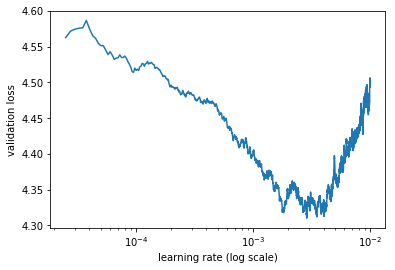

In [104]:
learner.sched.plot()

In [105]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                         
    0      4.139379   3.934061   0.305037  



[3.9340606661467197, 0.3050368029969002]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [106]:
#Commented to prevent from over-writing
#learner.save('lm1')

In [107]:
#Commented to prevent from over-writing
#learner.save_encoder('lm1_enc')

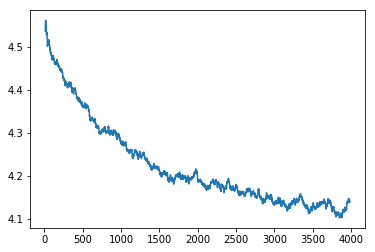

In [108]:
learner.sched.plot_loss()

In [87]:
learner.load('lm1')

In [88]:
m=learner.model

Lets see how text is generated by language model.

In [70]:
def generate_text(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s,"\n")
    for i in range(l):
        n = res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        print(itos[n], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))
    print('...')

In [90]:
generate_text(m, "Something is done")

Something is done 

. the only thing that i did n't like about this book was the fact that it was written by ...


In [92]:
generate_text(m, "that is not part of a ")

that is not part of a  

few of the other reviewers have mentioned that the book is a good read . 
 xbos xfld 1 i ...


### 6.5 Classifier Tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data.

In [14]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [15]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
0
1


In [17]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [93]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [94]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

55702

In [68]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

Saving tokens

In [21]:
#np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
#np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

### 6.6 Classifer

Now we can create our final model, a classifier which is really a custom linear head over our trained amazon backbone. The steps to create the classifier model are similar to the ones for the LM.

Load pre-processed classifier tokens

In [50]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [51]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [52]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [53]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [54]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [55]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [56]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [57]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [58]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [31]:
learn

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(55702, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(55702, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.2)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=2, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1

In [32]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [33]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [34]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [35]:
learn.freeze_to(-1)

In [36]:
#Just to ignore too many warnings
import warnings; warnings.simplefilter('ignore')

 78%|███████▊  | 4863/6250 [1:05:33<19:05,  1.21it/s, loss=1.37] 

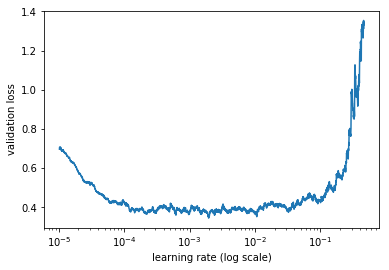

In [37]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [38]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.350102   0.276371   0.884308  


[0.2763705328519528, 0.8843076921976529]

In [39]:
# In comments to save from accidental overwriting of file
#learn.save('clas_0')

In [40]:
learn.load('clas_0')

In [41]:
learn.freeze_to(-2)

In [42]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                          
    0      0.282571   0.215788   0.914308  


[0.21578779692374742, 0.914307692527771]

In [43]:
# In comments to save from accidental overwriting of file
#learn.save('clas_1')

In [62]:
learn.load('clas_1')

In [63]:
#learn.unfreeze()
learn.freeze_to(-2)

In [64]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                          
    0      0.255143   0.201293   0.920731  


[0.2012933367720017, 0.9207307686805725]

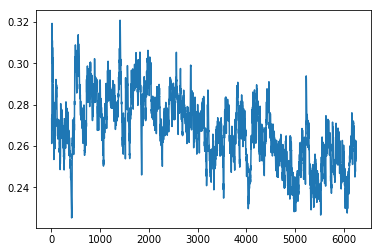

In [65]:
learn.sched.plot_loss()

In [67]:
# In comments to save from accidental overwriting of file
#learn.save('clas_2')

In [59]:
learn.load('clas_2')

In [69]:
learn.unfreeze()

In [70]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.261098   0.193033   0.927885  


[0.19303346471259228, 0.9278846154946547]

In [71]:
# In comments to save from accidental overwriting of file
#learn.save('clas_3')

## 7. Model Evalutation and validation

In [142]:
def generate_prediction(m, sen):
    #set batch size to 1
    m[0].bs=1
    #turn off dropout
    m.eval()
    #reset hidden state
    m.reset()  
    
    #sentence to be classified
    sen = sen
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    
    #converting sentence into numerical representation
    #print('numeric representation: ' + str(idxs))
    idxs = np.transpose(idxs)
    
    #print('Value of idxs: ' + str(idxs)) 
    
    #get predictions from model
    p = m(VV(idxs))
    #print('Prediction: ' + str(p))
    #print(sen + ' - classification: ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    
    return to_np(torch.topk(p[0],1)[1])[0]

In [161]:
learn.load('clas_3')
m = learn.model

In [175]:
results = []
i=0
with tqdm(total=len(tok_val)) as pbar:
    while i < len(tok_val):
        results.append(generate_prediction(m,' '.join(tok_val[i])))
        i+=1
        pbar.update(1)

In [176]:
# val_labels are the labels from the dataset
print(len(val_labels))
# results are the predicted results
print(len(results))

26000
26000


In [177]:
preds = np.asarray(results)

In [183]:
print("Accuracy is {}".format(accuracy_score(val_labels, preds)*100))

Accuracy is 92.84615384615384


In [179]:
print(classification_report(val_labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     13040
           1       0.92      0.94      0.93     12960

   micro avg       0.93      0.93      0.93     26000
   macro avg       0.93      0.93      0.93     26000
weighted avg       0.93      0.93      0.93     26000



In [119]:
print(confusion_matrix(val_labels, preds))

[[11981  1059]
 [  801 12159]]


## 8. Conclusion

In [243]:
generate_prediction(m," This was a good product")

array([1])

In [244]:
generate_prediction(m," This was a bad product")

array([0])

In [245]:
generate_prediction(m,"Well this is the best quality")

array([1])

In [248]:
generate_prediction(m,"I picked this up as the Omen mouse I purchased on \
a whim was of excellent quality. I bought this specifically to throw into my \
work travel bag so I had a nice gaming mouse pad to use with my \
laptop while gaming in hotel rooms. I like the size and the no-frills appearance \
of it. The surface accomplishes the accuracy and resistance I like in a gaming \
mouse pad. I use a Razer Goliathus \"Control\" mouse pad at home on my desk and\
this provides similar results, only difference there is the Goliathus is made of\
cloth whereas this is made of the traditional spongy material mouse pads are commonly\
formed with and of course this is half the price.")

array([1])

In [249]:
generate_prediction(m,"OMEN4LYFe")

array([1])

In [250]:
generate_prediction(m,"Love the size and quality of this mouse pad looks like its going to last for a long time,I am truly impressed")

array([1])

In [256]:
generate_prediction(m,"I bought this product believing it would be \"clear\" \
as the description says. While it is kind of clear, it is a milky clear and so\
on my black keyboard, it shows up cloudy. If you don't mind the cloudy look, \
it does seem to be durable and after getting used to the difference from the \
keys it is easy to use on my keyboard. I was just very disappointed that it is \
obviously there. So while I believe it to be a good product I would not buy it\
again because it is not actually clear. (the reason I expected to not be able\
to see it is because my husband was using a laptop for a long time before \
noticing it had a keyboard cover on it! I expected the same from this purchase")

array([0])

# Seems our model is good at prediciting the sentiment 